In [1]:
import tensorflow as tf
tf.__version__

'2.5.0'

In [2]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.layers import *
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import *
from tensorflow.keras.losses import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
train_dir =  'data/Training/'
train_paths = []
for label in os.listdir(train_dir):
    for file in os.listdir(train_dir+label):
        train_paths.append(train_dir+label+'/'+file)
random.shuffle(train_paths)
# show an example of the list
print(train_paths[0])

data/Training/meningioma/Tr-me_0882.jpg


In [5]:
test_dir = 'data/Testing/'
test_paths = []
for label in os.listdir(test_dir):
    for file in os.listdir(test_dir+label):
        test_paths.append(test_dir+label+'/'+file)
random.shuffle(test_paths)
# show an example of the list
print(test_paths[0])

data/Testing/glioma/Te-gl_0016.jpg


In [6]:
labels = os.listdir(train_dir)
labels

['glioma', 'meningioma', 'notumor', 'pituitary']

In [7]:
def open_images(paths):
    '''
    Opens a batch of images, given the image path(s) as a list
    '''
    images = []
    for path in paths:
        image = load_img(path, target_size=(128,128))
        image = np.array(image)/255.0
        images.append(image)
    return np.array(images)

In [8]:
def get_labels(paths):
    '''
    it is possible to get the label from the path, just split the path by "/" and index -2
    For example, /kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1020.jpg
    splitting by "/" gives ['kaggle','input','brain-tumor-mri-dataset','Training','pituitary','Tr-pi_1020.jpg']
    Now indexing -2 gives "pituitary"
    '''
    label = []
    for path in paths:
        path = path.split('/')[-2]
        label.append(labels.index(path))
    return label

In [9]:
def data_gen(data_paths, batch_size=1):
    img=[]
    lab=[]
    for i in range(0, len(data_paths), batch_size):
        paths = data_paths[i:i+batch_size]
        images = open_images(paths)
        img.append(open_images(paths).reshape(128, 128, 3))
        labels = get_labels(paths)
        lab.append(get_labels(paths))
        
        #yield images,np.array(labels)
    return np.array(img) , np.array(lab)

pituitary


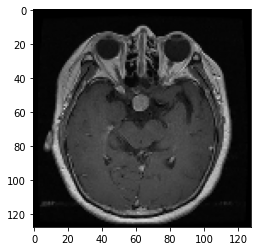

In [10]:
i = random.randint(0,len(train_paths))
label = train_paths[i].split('/')[-2] # This is how we get the label from the path train_paths[i]
image = open_images([train_paths[i]])
print(label)
plt.imshow(image[0])

In [11]:
model = Sequential()

model.add(Conv2D(64,(7,7), input_shape=(128, 128, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128,(7,7), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# Convolutional layer 3
model.add(Conv2D(128,(7,7), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# Convolutional layer 4
model.add(Conv2D(256,(7,7), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

 # Convolutional layer 5
model.add(Conv2D(256,(7,7), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# Convolutional layer 6
model.add(Conv2D(512,(7,7), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(units= 1024, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(units=4, activation='softmax'))

# model.summary()

# model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])

model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])

In [12]:
model_es = EarlyStopping(monitor = 'loss', min_delta = 1e-6, patience = 6, verbose = 1)
model_rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 6, verbose =1)
model_mcp = ModelCheckpoint(filepath = 'model_BEST.h5', monitor = 'sparse_categorical_accuracy', save_best_only = True, verbose = 1)


In [13]:
X_train, y_train = data_gen(train_paths)
X_test, y_test = data_gen(test_paths)

In [14]:
len(X_train)

5712

In [15]:
history = model.fit(X_train, y_train,               steps_per_epoch=len(X_train)//32, 
                    epochs=20, 
                    validation_data=(X_test, y_test), validation_steps= len(X_test)//32,
                    callbacks=[model_es, model_rlr, model_mcp])

Epoch 1/20
178/178 [==============================] - 48s 238ms/step - loss: 0.6605 - sparse_categorical_accuracy: 0.7675 - val_loss: 1.4316 - val_sparse_categorical_accuracy: 0.2967

Epoch 00001: sparse_categorical_accuracy improved from -inf to 0.76745, saving model to model_BEST.h5
Epoch 2/20
178/178 [==============================] - 39s 220ms/step - loss: 0.3819 - sparse_categorical_accuracy: 0.8604 - val_loss: 1.1387 - val_sparse_categorical_accuracy: 0.4905

Epoch 00002: sparse_categorical_accuracy improved from 0.76745 to 0.86037, saving model to model_BEST.h5
Epoch 3/20
178/178 [==============================] - 40s 223ms/step - loss: 0.2768 - sparse_categorical_accuracy: 0.9035 - val_loss: 1.8564 - val_sparse_categorical_accuracy: 0.3471

Epoch 00003: sparse_categorical_accuracy improved from 0.86037 to 0.90349, saving model to model_BEST.h5
Epoch 4/20
178/178 [==============================] - 40s 222ms/step - loss: 0.2494 - sparse_categorical_accuracy: 0.9120 - val_loss: 0.

In [16]:
# model_NEW = load_model('model_BEST.h5')

In [17]:
len(train_paths)/179

31.910614525139664

In [18]:
len(test_paths)

1311

In [19]:
model.evaluate(X_test, y_test)

41/41 [==============================] - 5s 83ms/step - loss: 0.0634 - sparse_categorical_accuracy: 0.9847


[0.06338106095790863, 0.9847444891929626]

Predicted: glioma
Actual: glioma
            probablity
glioma        0.999915
meningioma    0.000079
notumor       0.000004
pituitary     0.000002


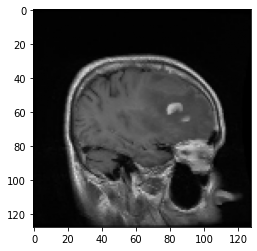

In [20]:
import pandas as pd
i = random.randint(0,len(test_paths))
images = open_images([test_paths[i]])
predicted = model.predict(images)[0]
predicted = np.argmax(predicted)
predicted = labels[predicted]
prob = model.predict(images)[0].round(6)

label = test_paths[i].split('/')[-2]
plt.imshow(images[0])
print('Predicted:', predicted)
print('Actual:', label)
print(pd.DataFrame(index = labels,data= prob,columns=["probablity"]))

In [21]:
from sklearn.metrics import classification_report, confusion_matrix

y_predicted = np.argmax(model.predict(X_test),axis=1).reshape(-1,1)


In [22]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.99      0.96      0.98       300
           1       0.96      0.97      0.97       306
           2       0.99      1.00      0.99       405
           3       1.00      1.00      1.00       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311



In [23]:
print(confusion_matrix(y_test, y_predicted))

[[289  11   0   0]
 [  3 298   5   0]
 [  0   0 405   0]
 [  0   1   0 299]]


In [24]:
history.history

{'loss': [0.66049724817276,
  0.38188502192497253,
  0.27679818868637085,
  0.2494061440229416,
  0.14604680240154266,
  0.12958844006061554,
  0.12158117443323135,
  0.09280819445848465,
  0.06832309067249298,
  0.06665009260177612,
  0.07287614792585373,
  0.03478751331567764,
  0.03307807445526123,
  0.0755910575389862,
  0.04086890444159508,
  0.03576884791254997,
  0.01951465755701065,
  0.012753917835652828,
  0.002562155481427908,
  0.0014119698898866773],
 'sparse_categorical_accuracy': [0.7674537897109985,
  0.8603696227073669,
  0.9034907817840576,
  0.9120465517044067,
  0.9500342011451721,
  0.956536591053009,
  0.9596167206764221,
  0.9681724905967712,
  0.9780972003936768,
  0.9779260754585266,
  0.9787816405296326,
  0.9878507852554321,
  0.9905886650085449,
  0.9779260754585266,
  0.9881930351257324,
  0.9904175400733948,
  0.992470920085907,
  0.9953798651695251,
  0.999144434928894,
  1.0],
 'val_loss': [1.4315921068191528,
  1.1386550664901733,
  1.8564339876174927,


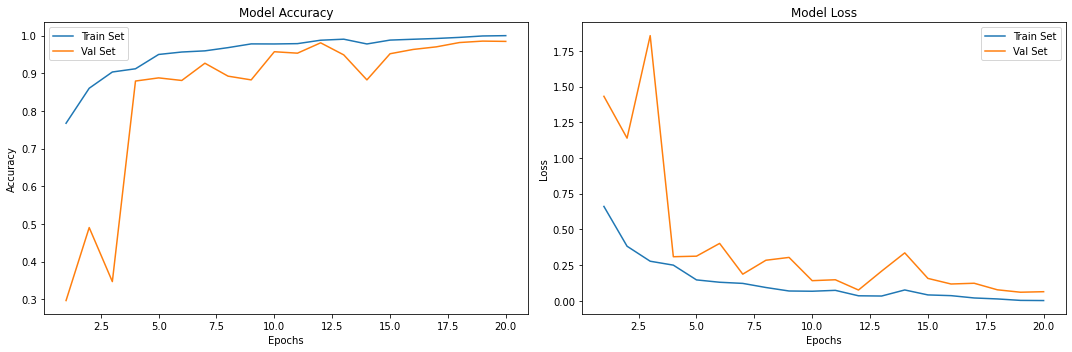

In [28]:
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [37]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    import itertools
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

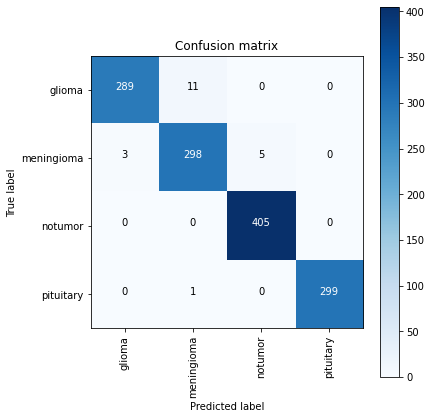

In [38]:
confusion_mtx = confusion_matrix(y_test, y_predicted)
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels), normalize=False)

In [ ]:
plt.hexbin

## 